In [1]:
"Créditos: La arquitectura de red neuronal Unet_Inception fue modificado del repositorio unet-variants de Jason Kugelman en su repositorio Github: https://github.com/jakugel/unet-variants/blob/main/unet_variant_models.py"

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import BinaryAccuracy, BinaryIoU
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
# Rutas de las carpetas
carpeta_fallas = "/kaggle/input/d/alvaroascanio/implem-fase2/fase2/Fallas"
carpeta_sismica = "/kaggle/input/d/alvaroascanio/implem-fase2/fase2/Sismica"

# Listar archivos en ambas carpetas
archivos_fallas = sorted(os.listdir(carpeta_fallas))
archivos_sismica = sorted(os.listdir(carpeta_sismica))

# Cargar y emparejar
fallas_data = []
sismica_data = []

for archivo_falla, archivo_sismica in zip(archivos_fallas, archivos_sismica):
    if archivo_falla == archivo_sismica:  # Verifica que los nombres coincidan
        # Cargar los arrays
        falla_array = np.load(os.path.join(carpeta_fallas, archivo_falla))
        sismica_array = np.load(os.path.join(carpeta_sismica, archivo_sismica))

        # Asegurarse de que las imágenes tengan la misma forma
        if falla_array.shape != (128, 128):
            falla_array = resize(falla_array, (128, 128))
        if sismica_array.shape != (128, 128):
            sismica_array = resize(sismica_array, (128, 128))

        # Añadir a las listas
        fallas_data.append(falla_array)
        sismica_data.append(sismica_array)
    else:
        print(f"Advertencia: Los archivos no coinciden: {archivo_falla} vs {archivo_sismica}")

images = np.array(sismica_data)
masks = np.array(fallas_data)


In [3]:
#Dividir dataset
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, random_state=13, test_size=0.2)
images_train = np.nan_to_num(images_train, nan=0.0)
images_test = np.nan_to_num(images_test, nan=0.0)

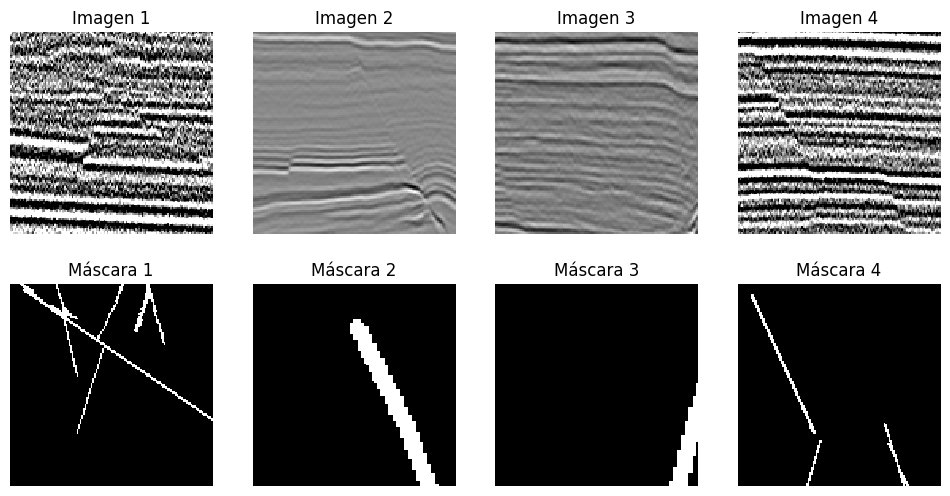

In [5]:
#Visualizar los datos
def visualize_data(images, masks, num_samples=5):
    plt.figure(figsize=(12, 6))

    for i in range(num_samples):
        # Mostrar la imagen
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i+1].T, cmap='gray', interpolation='Nearest')
        plt.title(f'Imagen {i + 1}')
        plt.axis('off')

        # Mostrar la máscara
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(masks[i+1].T, cmap='gist_gray', interpolation='Nearest')
        plt.title(f'Máscara {i + 1}')
        plt.axis('off')

    plt.savefig("patches_unet_inc.svg", format="svg")
    plt.show()

visualize_data(images_train, masks_train, num_samples=4)

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Input, Activation, Add, GlobalAveragePooling2D, Reshape, Dense, multiply, Permute, maximum, Concatenate, Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [9]:
def inception_unet(filters, output_channels, width=None, height=None, input_channels=1):
    def InceptionModule(inputs, filters):
        tower0 = Conv2D(filters, (1, 1), padding='same')(inputs)
        tower0 = BatchNormalization()(tower0)
        tower0 = Activation('relu')(tower0)

        tower1 = Conv2D(filters, (1, 1), padding='same')(inputs)
        tower1 = BatchNormalization()(tower1)
        tower1 = Activation('relu')(tower1)
        tower1 = Conv2D(filters, (3, 3), padding='same')(tower1)
        tower1 = BatchNormalization()(tower1)
        tower1 = Activation('relu')(tower1)

        tower2 = Conv2D(filters, (1, 1), padding='same')(inputs)
        tower2 = BatchNormalization()(tower2)
        tower2 = Activation('relu')(tower2)
        tower2 = Conv2D(filters, (3, 3), padding='same')(tower2)
        tower2 = Conv2D(filters, (3, 3), padding='same')(tower2)
        tower2 = BatchNormalization()(tower2)
        tower2 = Activation('relu')(tower2)

        tower3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
        tower3 = Conv2D(filters, (1, 1), padding='same')(tower3)
        tower3 = BatchNormalization()(tower3)
        tower3 = Activation('relu')(tower3)

        inception_module = concatenate([tower0, tower1, tower2, tower3], axis=3)

        return inception_module

    def deconv2d(layer_input, filters):
        u = Conv2DTranspose(filters, 2, strides=(2, 2), padding='same')(layer_input)
        u = BatchNormalization()(u)
        u = Activation('relu')(u)

        return u

    inputs = Input(shape=(width, height, input_channels))

    conv1 = InceptionModule(inputs, filters)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = InceptionModule(pool1, filters * 2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = InceptionModule(pool2, filters * 4)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = InceptionModule(pool3, filters * 8)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = InceptionModule(pool4, filters * 16)

    up6 = deconv2d(conv5, filters * 8)
    up6 = InceptionModule(up6, filters * 8)
    merge6 = concatenate([conv4, up6], axis=3)

    up7 = deconv2d(merge6, filters * 4)
    up7 = InceptionModule(up7, filters * 4)
    merge7 = concatenate([conv3, up7], axis=3)

    up8 = deconv2d(merge7, filters * 2)
    up8 = InceptionModule(up8, filters * 2)
    merge8 = concatenate([conv2, up8], axis=3)

    up9 = deconv2d(merge8, filters)
    up9 = InceptionModule(up9, filters)
    merge9 = concatenate([conv1, up9], axis=3)

    outputs = Conv2D(output_channels, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid')(merge9)

    model = Model(inputs=inputs, outputs=outputs)

    return model


In [10]:
model = inception_unet(filters=2, output_channels=1, width=128, height=128, input_channels=1)

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │          4 │ input_layer[0][0] │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │          4 │ input_layer[0][0] │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │          8 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │          8 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │         38 │ activation_3[0][… │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (MaxPooling2D)      │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │          4 │ input_layer[0][0] │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │         38 │ activation_1[0][… │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │         38 │ conv2d_4[0][0]    │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │          4 │ max_pooling2d[0]… │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │          8 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │          8 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │          8 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │          8 │ conv2d_6[0][0]  

 Total params: 74,843 (292.36 KB)

 Trainable params: 73,679 (287.81 KB)

 Non-trainable params: 1,164 (4.55 KB)

In [12]:
#Hiperparámetros configurables
lr = 1e-4
batch_size = 32
epochs = 25
#Compilar modelo
optimizer= tf.optimizers.Adam(learning_rate=lr)
loss_fn= tf.keras.losses.BinaryCrossentropy(from_logits=False)
metric = [tf.keras.metrics.Precision(),BinaryIoU(target_class_ids=[1], threshold=0.5, name=None, dtype=None), BinaryAccuracy(dtype=None, threshold=0.5)]
model.compile(optimizer=optimizer, loss=loss_fn, metrics=metric)

In [13]:
historia = model.fit(images_train, masks_train, epochs=epochs, batch_size=batch_size, shuffle=True,validation_split=0.2)

Epoch 1/25


I0000 00:00:1735613038.783056     101 service.cc:145] XLA service 0x7c8ca0003400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735613038.783106     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/291 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - binary_accuracy: 0.3553 - binary_io_u: 0.0210 - loss: 0.8239 - precision: 0.0213   

I0000 00:00:1735613062.289886     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - binary_accuracy: 0.4711 - binary_io_u: 0.0446 - loss: 0.7533 - precision: 0.0210

I0000 00:00:1735613094.065603      99 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_6', 24 bytes spill stores, 24 bytes spill loads



291/291 ━━━━━━━━━━━━━━━━━━━━ 96s 139ms/step - binary_accuracy: 0.4715 - binary_io_u: 0.0447 - loss: 0.7531 - precision: 0.0210 - val_binary_accuracy: 0.9383 - val_binary_io_u: 0.0275 - val_loss: 0.5243 - val_precision: 0.0386
Epoch 2/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - binary_accuracy: 0.8499 - binary_io_u: 0.0254 - loss: 0.5447 - precision: 0.0285 - val_binary_accuracy: 0.9436 - val_binary_io_u: 0.0228 - val_loss: 0.4313 - val_precision: 0.0337
Epoch 3/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - binary_accuracy: 0.9359 - binary_io_u: 0.0228 - loss: 0.4325 - precision: 0.0324 - val_binary_accuracy: 0.9628 - val_binary_io_u: 0.0184 - val_loss: 0.3727 - val_precision: 0.0376
Epoch 4/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - binary_accuracy: 0.9614 - binary_io_u: 0.0156 - loss: 0.3553 - precision: 0.0307 - val_binary_accuracy: 0.9730 - val_binary_io_u: 0.0100 - val_loss: 0.3095 - val_precision: 0.0365
Epoch 5/25
291/291 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - binary_acc

In [14]:
#Metricas de entrenamiento
Loss = historia.history['loss']
IoU = historia.history['binary_io_u']
Precision = historia.history['precision']
Accuracy = historia.history['binary_accuracy']


#Métricas de validación
Val_Loss = historia.history['val_loss']
Val_IoU = historia.history['val_binary_io_u']
Val_Precision = historia.history['val_precision']
Val_Accuracy = historia.history['val_binary_accuracy']


In [15]:
import csv
with open("training_metrics_inc.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Loss", "IoU", "Precision", "Accuracy"]) 
    for loss, iou, precision, accuracy in zip(Loss, IoU, Precision, Accuracy):
        writer.writerow([loss, iou, precision, accuracy])

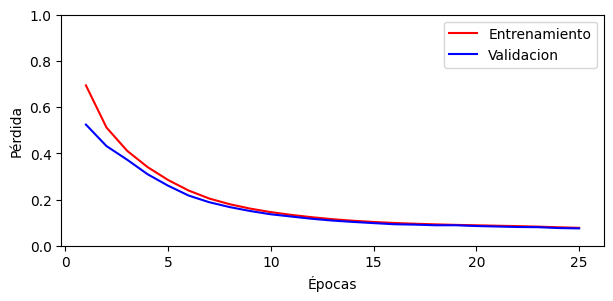

In [16]:
#Grafica de Pérdida
epochs_range = range(1, len(Loss) + 1)
plt.figure(figsize=(7, 3))
plt.plot(epochs_range, Loss, color='red', label='Entrenamiento')
plt.plot(epochs_range, Val_Loss, color='blue', label= 'Validacion')
plt.ylim(0,1)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.savefig("loss_unet_inception.svg", format="svg")
plt.show()

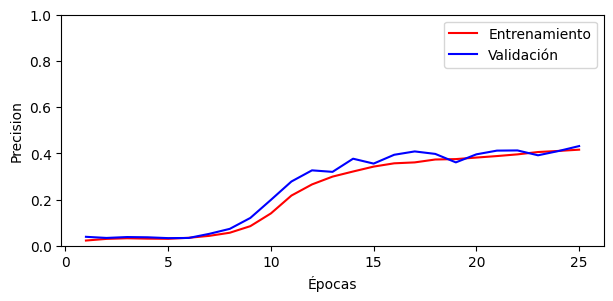

In [17]:
#Gráfica de Precisión
plt.figure(figsize=(7, 3))
plt.plot(epochs_range, Precision, color='red', label='Entrenamiento')
plt.plot(epochs_range, Val_Precision, color='blue', label='Validación')
plt.ylim(0,1)
plt.xlabel('Épocas')
plt.ylabel('Precision')
plt.legend()
plt.savefig("precision_unet_inception.svg", format="svg")
plt.show()

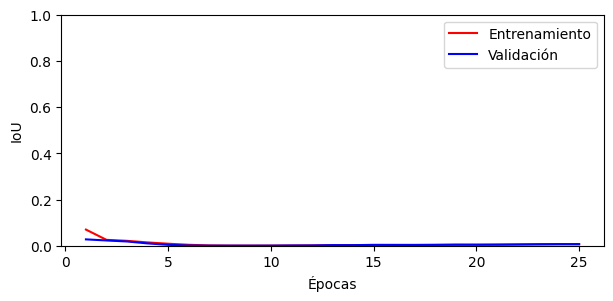

In [18]:
#Gráfica de IoU
plt.figure(figsize=(7, 3))
plt.plot(epochs_range, IoU, color='red', label='Entrenamiento')
plt.plot(epochs_range, Val_IoU, color='blue', label='Validación')
plt.ylim(0,1)
plt.xlabel('Épocas')
plt.ylabel('IoU')
plt.legend()
plt.savefig("IoU_unet_inception.svg", format="svg")
plt.show()


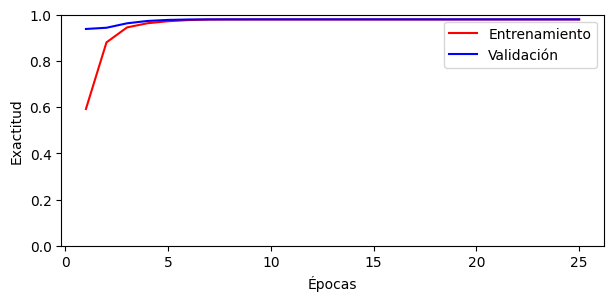

In [19]:
#Gráfica de Accuracy
plt.figure(figsize=(7, 3))
plt.plot(epochs_range, Accuracy, color='red', label='Entrenamiento')
plt.plot(epochs_range, Val_Accuracy, color='blue', label='Validación')
plt.ylim(0,1)
plt.xlabel('Épocas')
plt.ylabel('Exactitud')
plt.legend()
plt.savefig("Accuracy_unet_inception.svg", format="svg")
plt.show()


In [20]:
predicciones = model.predict(images_test)

91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step


In [21]:
#Evaluar modelo con los datos de test.
historia2 = model.evaluate(
    x=images_test,
    y=masks_test,
    batch_size=None,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    return_dict=False,)

91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - binary_accuracy: 0.9789 - binary_io_u: 0.0061 - loss: 0.0786 - precision: 0.4325


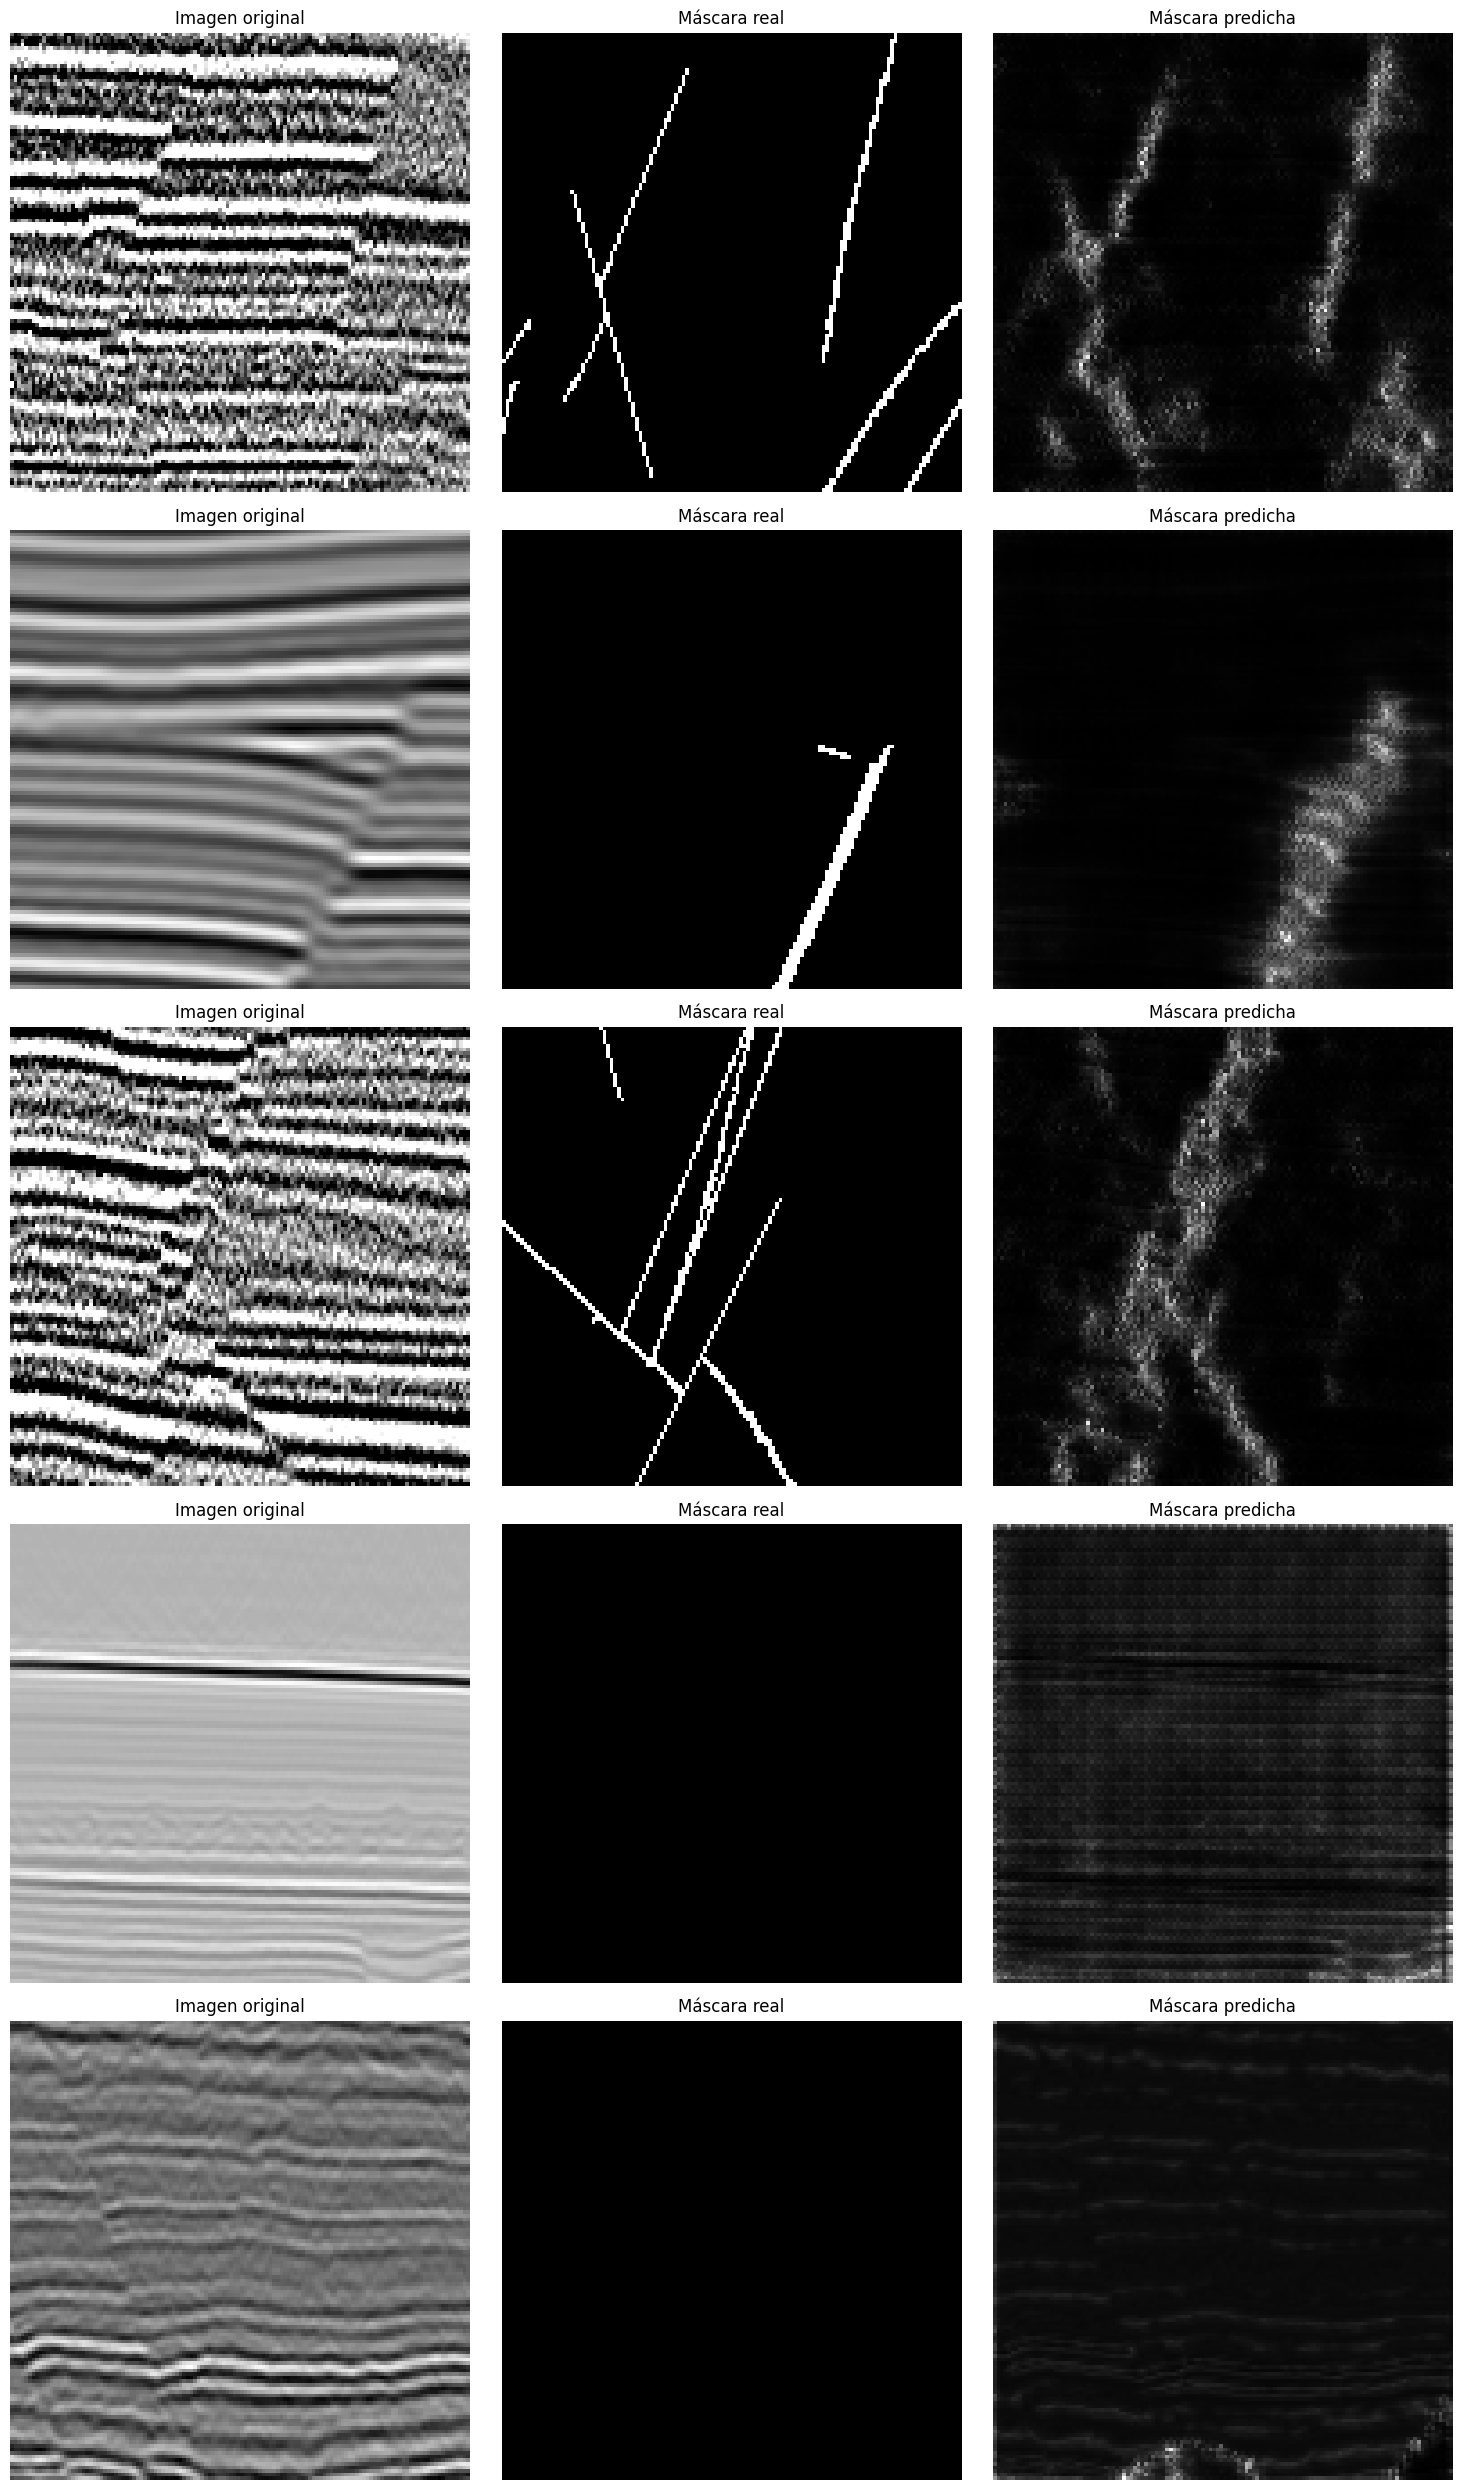

In [22]:
def mostrar_resultados(imagenes, mascaras_reales, mascaras_predichas, num_ejemplos=5):
    plt.figure(figsize=(15, num_ejemplos * 5))
    
    for i in range(num_ejemplos):
        # Imagen original
        plt.subplot(num_ejemplos, 3, i * 3 + 1)
        plt.imshow(imagenes[i].T, cmap="gray")
        plt.title("Imagen original")
        plt.axis("off")

        # Máscara real
        plt.subplot(num_ejemplos, 3, i * 3 + 2)
        plt.imshow(mascaras_reales[i].T, cmap="gray")
        plt.title("Máscara real")
        plt.axis("off")

        # Máscara predicha
        plt.subplot(num_ejemplos, 3, i * 3 + 3)
        plt.imshow(mascaras_predichas[i, ..., 0].T, cmap="gray")
        plt.title("Máscara predicha")
        plt.axis("off")

    plt.savefig("Resultado_Inception_UNet.svg", format="svg")
    plt.tight_layout()
    plt.show()

# Mostrar resultados para las primeras 5 imágenes
mostrar_resultados(images_test, masks_test, predicciones, num_ejemplos=5)

In [23]:
# Guardar el modelo
model.save("/kaggle/working/Inception_Unet.keras")

# Cargar el modelo
from tensorflow.keras.models import load_model
modelo_cargado = load_model("/kaggle/working/Inception_Unet.keras")

# Confirmar que el modelo cargado funciona.
modelo_cargado.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │          4 │ input_layer[0][0] │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │          4 │ input_layer[0][0] │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │          8 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │          8 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │         38 │ activation_3[0][… │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (MaxPooling2D)      │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │          4 │ input_layer[0][0] │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │         38 │ activation_1[0][… │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │         38 │ conv2d_4[0][0]    │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │          4 │ max_pooling2d[0]… │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │          8 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │          8 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │          8 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │          8 │ conv2d_6[0][0]  

 Total params: 222,203 (867.98 KB)

 Trainable params: 73,679 (287.81 KB)

 Non-trainable params: 1,164 (4.55 KB)

 Optimizer params: 147,360 (575.63 KB)